In [1]:
!pip install dgl
from os import listdir
import dgl
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

     |████████████████████████████████| 3.0MB 3.5MB/s 


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
epochs = int(input("Enter number of epochs: "))
learning_rate = float(input("Enter learning rate: "))

Enter number of epochs: 260
Enter learning rate: 0.01


In [6]:
filename = "/content/drive/My Drive/adaptec2.nets"

edge_file = "/content/add_edges_3.py"
edge_file_handle = open(edge_file, "w+")

node_count = 0

with open(filename,encoding="utf8") as f:
    netSection = False
    edges = 0
    lineCount = 0
    src=[]
    dest=[]
    for line in f:
        lineCount += 1
        #Newline
        if len(line) < 2:
            continue
            
        # Comments
        if line[0] == '#':
            continue
        #print(line)
        splitLine = line.split()
        #print("Words = ", len(splitLine))
        if(splitLine[0] == 'NetDegree'):
            
            if edges > 0: #Previous NetDegree not complete!
                print("Missed an edge at line: ", lineCount-1)
                
            edges = int(splitLine[2])
            netSection = True
            src=[]
            dest=[]
            #G.add_nodes(num)
            
        elif netSection == True:
          node_name = splitLine[0][1:]
          node_val  = int(node_name)
          if node_count < node_val+1:
              node_count = node_val+1
          
          if(splitLine[1] == 'O'):
              src.append(node_name)
              edges -= 1
          elif(splitLine[1] == 'I'):
              dest.append(node_name)
              edges -= 1
      
        if netSection == True:
            if edges == 0:
                if (len(src)<1):
                    print("No source edge, skipping")
                    continue
                if (len(dest)<1):
                    print("No dest edge, skipping")
                    continue
                    
                netSection = False
                for des_idx in range(len(dest)):
                    cmd = "G.add_edges("+src[0]+","+dest[des_idx]+")"+"\n"
                    edge_file_handle.write(cmd)
                    
        #if lineCount > 100:
        #    break


edge_file_handle.close()


Streaming output truncated to the last 5000 lines.
No source edge, skipping
No source edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No dest edge, skipping
No

In [7]:
G = dgl.DGLGraph()
G.add_nodes(node_count)
exec(open(edge_file).read())
print("Nodes = ", G.number_of_nodes())
print("Edges = ", G.number_of_edges())

Nodes =  255023
Edges =  799643


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
embed = nn.Embedding(G.number_of_nodes(),6)

In [0]:
G.ndata['feat'] = embed.weight

In [0]:
from dgl.nn.pytorch import GraphConv

In [0]:
class GCN(nn.Module):
    def __init__(self,input_size,hidden_size,num_classes):
        super(GCN,self).__init__()
        self.conv1 = GraphConv(input_size,hidden_size)
        self.conv2 = GraphConv(hidden_size,num_classes)
    
    def forward(self,G,inputs):
        h = self.conv1(G,inputs)
        h = torch.relu(h) 
        h = self.conv2(G,h)
        return h

In [0]:
net = GCN(6,5,20)

In [0]:
inputs = embed.weight
a = np.linspace(0,G.number_of_nodes()-1,20,dtype=int)
labelled_nodes = torch.tensor(a)
labels = torch.tensor([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19])

# Training Model

In [15]:
import itertools
import time

optimizer = torch.optim.Adam(itertools.chain(net.parameters(), embed.parameters()), lr=learning_rate)
all_logits = []

start_time = time.time()

for epoch in range(epochs):
    logits = net(G, inputs)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[labelled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print('Epoch {} | Loss: {}'.format(epoch + 1, loss.item()))

end_time = time.time()
print("Training Time: {}".format(end_time - start_time))

Epoch 1 | Loss: 2.9883530139923096
Epoch 2 | Loss: 2.9697396755218506
Epoch 3 | Loss: 2.9514646530151367
Epoch 4 | Loss: 2.9332454204559326
Epoch 5 | Loss: 2.9150242805480957
Epoch 6 | Loss: 2.8972291946411133
Epoch 7 | Loss: 2.879185914993286
Epoch 8 | Loss: 2.860976219177246
Epoch 9 | Loss: 2.8423445224761963
Epoch 10 | Loss: 2.822953462600708
Epoch 11 | Loss: 2.8030641078948975
Epoch 12 | Loss: 2.7826573848724365
Epoch 13 | Loss: 2.761532783508301
Epoch 14 | Loss: 2.739663600921631
Epoch 15 | Loss: 2.7170064449310303
Epoch 16 | Loss: 2.693488121032715
Epoch 17 | Loss: 2.6691980361938477
Epoch 18 | Loss: 2.6441009044647217
Epoch 19 | Loss: 2.618114471435547
Epoch 20 | Loss: 2.5912928581237793
Epoch 21 | Loss: 2.563789129257202
Epoch 22 | Loss: 2.5355875492095947
Epoch 23 | Loss: 2.5066909790039062
Epoch 24 | Loss: 2.477177381515503
Epoch 25 | Loss: 2.447108030319214
Epoch 26 | Loss: 2.41654896736145
Epoch 27 | Loss: 2.3855412006378174
Epoch 28 | Loss: 2.3541693687438965
Epoch 29 | Lo

In [0]:
pos = {}
node_to_cluster_map = np.zeros((G.number_of_nodes(),))
cluster_nodes = {} # Every value in key->value pair includes the cluster centre node as well.
for v in range(G.number_of_nodes()):
  pos[v] = all_logits[99][v].numpy()
  cls = pos[v].argmax()
  node_to_cluster_map[v] = cls
  if cluster_nodes.get(cls) :
    cluster_nodes[cls].append(v)
  else:
    cluster_nodes[cls] = []
    cluster_nodes[cls].append(v)

# Cluster Quality Metric #2 : Number of Nodes per Cluster Distribution

In [0]:
def number_of_nodes_per_cluster():
  number_dict = {} # Dictionary mapping the node label to the number of nodes in a particular cluster
  for key,value in cluster_nodes.items():
    number_dict[key] = len(value)

  number_dict = sorted(number_dict.items()) # Sorting dictionary by keys in increasing order

  for ix in number_dict:
    print("Number of Nodes in Cluster {} = {}\n".format(ix[0],ix[1]))

  return number_dict

In [18]:
number_dict = number_of_nodes_per_cluster()

Number of Nodes in Cluster 0 = 6136

Number of Nodes in Cluster 1 = 2693

Number of Nodes in Cluster 2 = 19978

Number of Nodes in Cluster 3 = 2680

Number of Nodes in Cluster 4 = 1907

Number of Nodes in Cluster 5 = 2585

Number of Nodes in Cluster 6 = 4712

Number of Nodes in Cluster 7 = 15465

Number of Nodes in Cluster 8 = 49437

Number of Nodes in Cluster 9 = 11501

Number of Nodes in Cluster 10 = 6919

Number of Nodes in Cluster 11 = 8095

Number of Nodes in Cluster 12 = 46188

Number of Nodes in Cluster 13 = 13260

Number of Nodes in Cluster 14 = 33064

Number of Nodes in Cluster 15 = 3233

Number of Nodes in Cluster 16 = 16789

Number of Nodes in Cluster 17 = 1129

Number of Nodes in Cluster 18 = 4541

Number of Nodes in Cluster 19 = 4711



# HashMap (Dictionary) for easy visualization of networkx graph
- Dictionary to map node numbers in a particular cluster to a standard count procedure of 0 to (n-1) 
- n = number of nodes in a particular cluster
- Cluster label is taken as input from user

In [0]:
num = int(input("Enter cluster number: "))

Enter cluster number: 10


In [0]:
standard_nodes_dict = {}

count = 0

for node in cluster_nodes[num]:
  standard_nodes_dict[node] = count
  count += 1

In [0]:
print(standard_nodes_dict.items())

dict_items([(32, 0), (33, 1), (34, 2), (35, 3), (38, 4), (39, 5), (64, 6), (65, 7), (69, 8), (72, 9), (73, 10), (74, 11), (88, 12), (89, 13), (90, 14), (92, 15), (93, 16), (95, 17), (100, 18), (101, 19), (102, 20), (108, 21), (116, 22), (117, 23), (118, 24), (126, 25), (127, 26), (128, 27), (130, 28), (131, 29), (145, 30), (146, 31), (155, 32), (164, 33), (165, 34), (166, 35), (182, 36), (184, 37), (185, 38), (186, 39), (208, 40), (209, 41), (232, 42), (233, 43), (234, 44), (244, 45), (245, 46), (246, 47), (251, 48), (260, 49), (261, 50), (262, 51), (300, 52), (301, 53), (302, 54), (303, 55), (316, 56), (318, 57), (319, 58), (320, 59), (321, 60), (322, 61), (326, 62), (327, 63), (348, 64), (349, 65), (350, 66), (366, 67), (367, 68), (368, 69), (384, 70), (385, 71), (386, 72), (387, 73), (388, 74), (389, 75), (399, 76), (400, 77), (401, 78), (402, 79), (403, 80), (404, 81), (405, 82), (406, 83), (407, 84), (435, 85), (461, 86), (464, 87), (482, 88), (488, 89), (489, 90), (490, 91), (500

# Clustering Visualisation: Cluster Quality Metric # 3
- Visualisation for any generic cluster label taken as input from user

In [0]:
# dict_keys = list(standard_nodes_dict.keys())

# input_edges = G.in_edges(dict_keys, form='uv')

# ax = input_edges[0].numpy()

# ax = [i for i in ax if i in standard_nodes_dict.keys()]

# print(ax)

In [0]:
src = []
dst = []

In [0]:
def build_graph():

  dict_keys = list(standard_nodes_dict.keys())

  input_edges = G.in_edges(dict_keys, form='uv')

  src = input_edges[0].numpy()
  dst = input_edges[1].numpy()

  m = src.shape[0]
  src1 = []
  dst1 = []

  for ix in range(m):
    if src[ix] not in standard_nodes_dict.keys():
      continue
    else:
      src1.append(src[ix])
      dst1.append(dst[ix])

  src1 = np.array(src1)
  dst1 = np.array(dst1)

  j = 0
  for num in src1:
    num = standard_nodes_dict.get(num)
    src1[j] = num
    j += 1

  i = 0
  for num1 in dst1:
      num1 = standard_nodes_dict[num1]
      dst1[i] = num1
      i += 1

  u = np.concatenate([src1,dst1])
  v = np.concatenate([dst1,src1])

  return dgl.DGLGraph((u,v))

In [0]:
G1 = build_graph()

In [0]:
print("Nodes = {}".format(G1.number_of_nodes()))
print("Edges = {}".format(G1.number_of_edges()))

Nodes = 38847
Edges = 80578


In [0]:
nx_G1 = G1.to_networkx().to_undirected()

In [0]:
nx.write_edgelist(nx_G1,"/content/cluster10.csv")

In [0]:
# pos1 = nx.kamada_kawai_layout(nx_G1) # Session crashes on running this cell

In [0]:
# plt.style.use("seaborn")

In [0]:
# nx.draw(nx_G1,pos1,with_labels=True,node_color=[[0.7,0.7,0.7]])
# plt.show()

# Cluster Quality Metric # 1: Total number of edges between nodes which belong to different clusters and intercluster score
- Intercluster Score = No. of edges between 2 clusters / Sum of the number of nodes in the two clusters

In [0]:
def find_cluster(node):
  return node_to_cluster_map[node]

In [20]:
edges_dict = {}

start = time.time()

for node in range(G.number_of_nodes()):
  #print("Node {}".format(node))
  # node is the source node for all out edges

  out_edges = G.out_edges(node,form='uv')

  src = out_edges[0]
  if(len(src) < 1):
    continue
    
  if src[-1] != node:
    print("Source node is different from node")
  dst = out_edges[1]

  src_cluster = find_cluster(node)

  for ix in range(src.shape[0]):
    #node_n = src[ix]
    node_n = node
    node_m = dst[ix]

    #cluster_n = find_cluster(node_n)
    cluster_n = src_cluster
    cluster_m = find_cluster(node_m)

    if cluster_n != cluster_m:
      from_cluster = cluster_n
      to_cluster = cluster_m
      if from_cluster > to_cluster:
        from_cluster = cluster_m
        to_cluster = cluster_n

      if (from_cluster,to_cluster) not in edges_dict.keys():
        edges_dict[(from_cluster,to_cluster)] = 1
      else:
        edges_dict[(from_cluster,to_cluster)] += 1


for key,value in edges_dict.items():
  num = value
  nodes_1 = number_dict[int(key[0])][1]
  nodes_2 = number_dict[int(key[1])][1]
  num2 = value/int((nodes_1 + nodes_2))
  num2 = round(num2,4)

  edges_dict[key] = (num,num2)


end = time.time()
print("\nTime taken: {}".format(end - start))


Time taken: 37.979336977005005


In [21]:
count = 0
for key,value in edges_dict.items():
  count += 1
print("Entries in edges_dict = {}".format(count))

Entries in edges_dict = 190


In [22]:
for key, value in (edges_dict.items()):
  print(key,value)

(0.0, 2.0) (1938, 0.0742)
(0.0, 8.0) (6398, 0.1151)
(1.0, 12.0) (1723, 0.0352)
(1.0, 7.0) (792, 0.0436)
(12.0, 14.0) (40108, 0.5061)
(8.0, 15.0) (2976, 0.0565)
(2.0, 15.0) (909, 0.0392)
(8.0, 14.0) (43965, 0.5329)
(10.0, 18.0) (673, 0.0587)
(2.0, 10.0) (3719, 0.1383)
(14.0, 16.0) (13213, 0.265)
(6.0, 16.0) (1603, 0.0746)
(8.0, 16.0) (21378, 0.3228)
(10.0, 16.0) (2879, 0.1214)
(5.0, 14.0) (1504, 0.0422)
(8.0, 9.0) (16373, 0.2687)
(2.0, 11.0) (3442, 0.1226)
(11.0, 16.0) (3168, 0.1273)
(0.0, 10.0) (1271, 0.0974)
(13.0, 15.0) (899, 0.0545)
(8.0, 18.0) (7407, 0.1372)
(8.0, 17.0) (1136, 0.0225)
(8.0, 12.0) (65078, 0.6806)
(13.0, 14.0) (7696, 0.1661)
(0.0, 13.0) (1704, 0.0879)
(7.0, 14.0) (11576, 0.2385)
(8.0, 10.0) (8195, 0.1454)
(9.0, 14.0) (9728, 0.2183)
(0.0, 15.0) (408, 0.0435)
(7.0, 8.0) (18984, 0.2925)
(2.0, 16.0) (7741, 0.2105)
(15.0, 16.0) (965, 0.0482)
(7.0, 16.0) (5842, 0.1811)
(11.0, 13.0) (2308, 0.1081)
(12.0, 15.0) (2588, 0.0524)
(14.0, 19.0) (2585, 0.0684)
(10.0, 13.0) (2500, 0

In [0]:
edges_list = sorted(edges_dict.items(),reverse=True,key = lambda x: x[1])

In [24]:
edges_list[:10]

[((8.0, 12.0), (65078, 0.6806)),
 ((8.0, 14.0), (43965, 0.5329)),
 ((12.0, 14.0), (40108, 0.5061)),
 ((2.0, 8.0), (28464, 0.4101)),
 ((2.0, 12.0), (24495, 0.3702)),
 ((8.0, 16.0), (21378, 0.3228)),
 ((7.0, 8.0), (18984, 0.2925)),
 ((12.0, 16.0), (18939, 0.3007)),
 ((7.0, 12.0), (17742, 0.2878)),
 ((2.0, 14.0), (17699, 0.3337))]

In [0]:
keys_list = []
values_list = []

count = 0
for val in edges_list:
  count += 1
  keys_list.append(str(val[0]))
  values_list.append(val[1][0])
  if(count == 10):
    break

In [26]:
print(keys_list)

['(8.0, 12.0)', '(8.0, 14.0)', '(12.0, 14.0)', '(2.0, 8.0)', '(2.0, 12.0)', '(8.0, 16.0)', '(7.0, 8.0)', '(12.0, 16.0)', '(7.0, 12.0)', '(2.0, 14.0)']


In [27]:
values_list

[65078, 43965, 40108, 28464, 24495, 21378, 18984, 18939, 17742, 17699]

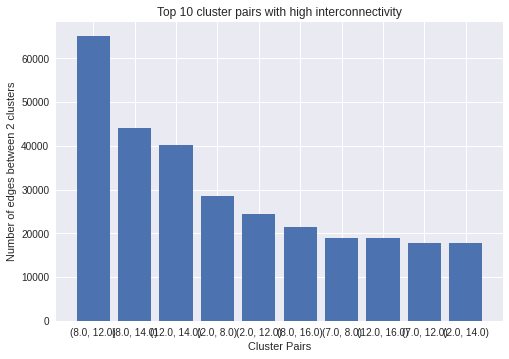

In [28]:
plt.style.use("seaborn")
plt.bar(keys_list,values_list)
plt.ylabel("Number of edges between 2 clusters")
plt.xlabel("Cluster Pairs")
plt.title("Top 10 cluster pairs with high interconnectivity")
plt.show()